In [1]:
# Install PennyLane and PySCF
!pip install Pennylane
!pip install PySCF

### Import your favourite libraries

In [2]:
import pennylane as qml
from pennylane import numpy as pnp

## Initial state preparation

Initial states obtained from affordable post-Hartree-Fock calculations can be used to make the quantum workflow more performant. For instance, configuration interaction (CI) and coupled cluster (CC) calculations with single and double (SD) excitations can be performed using PySCF and the resulting wave function can be used as the initial state in the quantum algorithm. PennyLane provides the `import_state()` function that takes a PySCF object, extracts the wave function and returns a state vector in the computational basis that can be used in a quantum circuit. (Source: [Using PennyLane with PySCF and OpenFermion](https://pennylane.ai/qml/demos/tutorial_qchem_external/))

The currently supported methods are configuration interaction with singles and doubles (CISD), coupled cluster (CCSD), density-matrix renormalization group (DMRG) and semistochastic heat-bath configuration interaction (SHCI). These are basically different ways of considering which electrons have an effect on others.

We now show how this works on the linear H3+ molecule as an example.

Let’s take this opportunity to create the Hartree-Fock initial state, to compare other states against it later on.

In [3]:
#create the Hartree-Fock initial state, to compare other states against it later on.
hf_primer = ([[3, 0, 0]], pnp.array([1.0]))
wf_hf = qml.qchem.import_state(hf_primer)

### CISD states

CISD stands for configuration interaction singles and doubles. The first line of attack for initial state preparation is often a CISD calculation, performed with the PySCF library. CISD is unsophisticated, but it is fast. It will not be of much help for strongly correlated molecules, but it is better than Hartree-Fock. CISD includes only those configurations that differ from the Hartree–Fock determinant by at most two occupied spinorbitals. Here is the code example:

In [4]:
import pyscf

R = 1.2

# Create the H3+ molecule from PySCF
mol = pyscf.M(atom = [["H",(0,0,0)],["H",(0,0,R)],["H",(0,0,2*R)]],charge = 1)
# Perfrom Hartree-Fock and then CISD
myhf = mol.HF.run()
myci = myhf.CISD().run()

# Import the initial state into PennyLane
wf_cisd = qml.qchem.import_state(myci,tol = 1e-1)

converged SCF energy = -1.13616963888333
E(RCISD) = -1.182690605466229  E_corr = -0.0465209665828972


### CCSD states
CCSD stands for Coupled-cluster with Single and Double excitations.
The function `import_state()` is general and works similarly for CCSD. It can automatically detect the input type and apply the appropriate conversion protocol.

In [5]:
#Perform CCSD
mycc = pyscf.cc.CCSD(myhf).run()
# Import the initial state into PennyLane
wf_ccsd = qml.qchem.import_state(mycc,tol = 1e-1)


E(CCSD) = -1.182690605467345  E_corr = -0.04652096658401336


<class 'pyscf.cc.ccsd.CCSD'> does not have attributes  converged


### Compare the ground state energy obtained with each initial state prep

Let us now demonstrate how the choice of a better initial state shortens the runtime of VQE for obtaining the ground-state energy of a molecule. As a first step, create our linear  H3+ molecule, a device, and a simple VQE circuit with single and double excitations:

In [6]:
# Generate the molecular Hamiltonian for H3+
symbols= ["H","H","H"]
geometry = pnp.array([[0,0,0],[0,0,R/0.529],[0,0,2*R/0.529]])
molecule = qml.qchem.Molecule(symbols,geometry,charge = 1)

H3mol,qubits = qml.qchem.molecular_hamiltonian(molecule)
wires = list(range(qubits))
electrons = 2
orbitals = qubits 

# Create all possible excitations in H3+
singles, doubles = qml.qchem.excitations(electrons,orbitals)
#combine all the the possible excitations
excitations = singles + doubles 
print(excitations)

[[0, 2], [0, 4], [1, 3], [1, 5], [0, 1, 2, 3], [0, 1, 2, 5], [0, 1, 3, 4], [0, 1, 4, 5]]


Now let’s run VQE with the Hartree-Fock initial state. We first build the VQE circuit:

In [7]:
# run VQE with the Hartree-Fock initial state
dev = qml.device("default.qubit",wires = qubits)
#Build the VQE circuit:
@qml.qnode(dev)
def circuit_VQE(theta, initial_state):
    qml.StatePrep(initial_state,wires = wires)
    #ansatz
    for i, excitation in enumerate(excitations):
        if len(excitation)==4:
            qml.DoubleExcitation(theta[i],wires= excitation)
        else:
            qml.SingleExcitation(theta[i],wires=excitation)  
    return qml.expval(H3mol)

Next, we create the VQE optimizer, initialize the variational parameters and run the VQE optimization.

(<Figure size 1200x700 with 1 Axes>, <Axes: >)

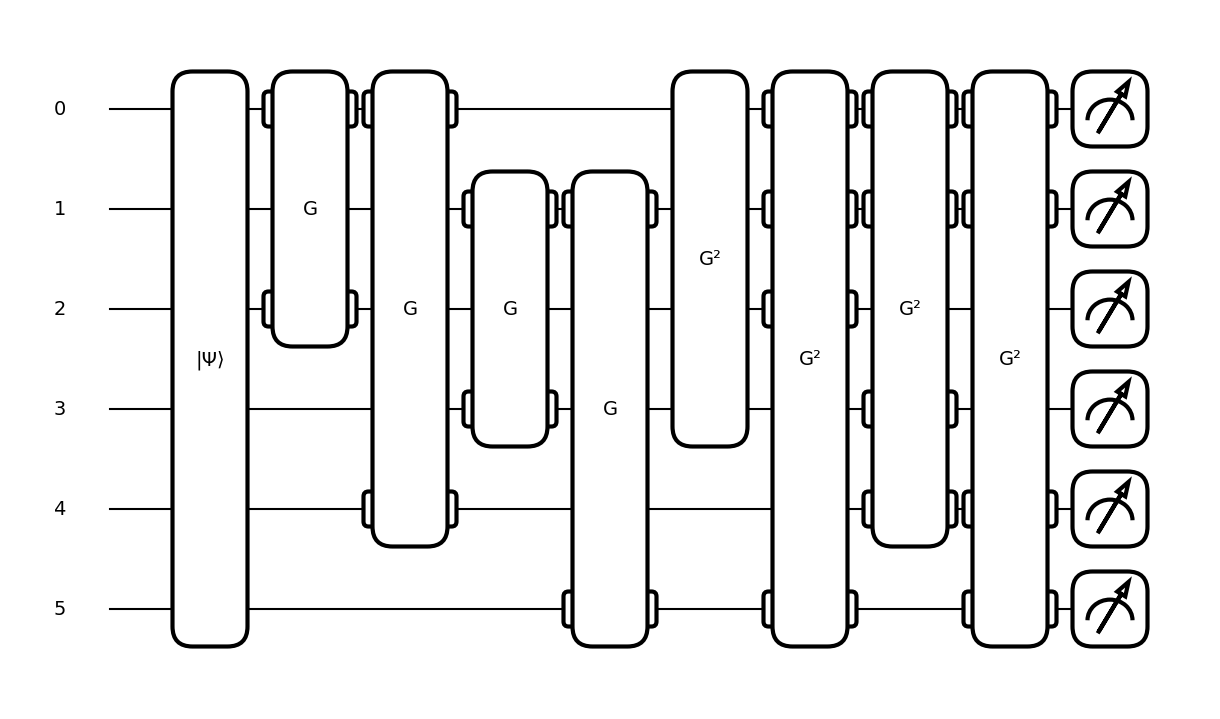

In [8]:
#Define optimizer and initialize parameters
opt = qml.GradientDescentOptimizer(stepsize = 0.4)
theta = pnp.array(pnp.zeros(len(excitations)),requires_grad = True)
#Draw circuit
qml.draw_mpl(circuit_VQE)(theta, initial_state = wf_hf)


In [9]:
delta_E = 10
results_hf =[]
tol = 1e-5
# run the VQE optimization loop until convergence threshold is reached
while abs(delta_E) > tol:
    #complete code here
    theta,prev_energy = opt.step_and_cost(circuit_VQE, theta, initial_state = wf_hf)
    new_energy = circuit_VQE(theta, initial_state = wf_hf )
    delta_E = new_energy - prev_energy
    results_hf.append(new_energy)
    if len(results_hf) % 5 == 0:
        print(f"Step = {len(results_hf)},  Energy = {new_energy:.6f} Ha")

print(f"Starting with HF state took {len(results_hf)} iterations until convergence.")

Step = 5,  Energy = -1.173803 Ha
Step = 10,  Energy = -1.179865 Ha
Step = 15,  Energy = -1.181626 Ha
Step = 20,  Energy = -1.182239 Ha
Step = 25,  Energy = -1.182461 Ha
Step = 30,  Energy = -1.182543 Ha
Starting with HF state took 31 iterations until convergence.


And compare with how things go when you run it with the CISD initial state:

In [10]:

delta_E = 10
results_cisd = []

while abs(delta_E) > tol:
    #complete code here
    theta,prev_energy = opt.step_and_cost(circuit_VQE, theta, initial_state = wf_cisd)
    new_energy  = circuit_VQE(theta, initial_state = wf_cisd )
    delta_E = new_energy - prev_energy
    results_cisd.append(new_energy)
    if len(results_cisd) % 5 == 0:
        print(f"Step = {len(results_cisd)},  Energy = {new_energy:.6f} Ha")
print(f"Starting with CISD state took {len(results_cisd)} iterations until convergence.")

Step = 5,  Energy = -1.175150 Ha
Step = 10,  Energy = -1.180406 Ha
Step = 15,  Energy = -1.181857 Ha
Step = 20,  Energy = -1.182329 Ha
Step = 25,  Energy = -1.182495 Ha
Starting with CISD state took 29 iterations until convergence.


And with the CCSD initial state:

In [11]:

delta_E = 10
results_ccsd = []

while abs(delta_E) > tol:
    #complete code here
    theta,prev_energy = opt.step_and_cost(circuit_VQE, theta, initial_state = wf_ccsd)
    new_energy  = circuit_VQE(theta, initial_state = wf_ccsd )
    delta_E = new_energy - prev_energy
    results_ccsd.append(new_energy)
    if len(results_ccsd) % 5 == 0:
        print(f"Step = {len(results_ccsd)},  Energy = {new_energy:.6f} Ha")
print(f"Starting with CCSD state took {len(results_ccsd)} iterations until convergence.")

Starting with CCSD state took 1 iterations until convergence.


Let’s visualize the comparison between the three initial states, and see that indeed we get to the ground state much faster by starting with the CISD and CCSD states than with the HF state.

ValueError: x and y must have same first dimension, but have shapes (1,) and (29,)

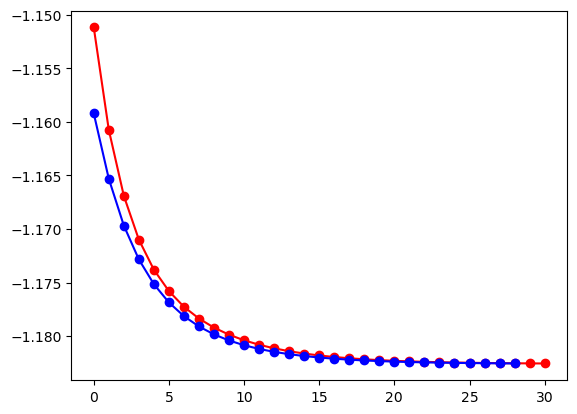

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(range(len(results_hf)), results_hf, color="r", marker="o", label="wf_hf")
ax.plot(range(len(results_cisd)), results_cisd, color="b", marker="o", label="wf_cisd")
ax.plot(range(len(results_ccsd)), results_cisd, color="c", marker="x", label="wf_ccsd")
ax.legend(fontsize=16)
ax.tick_params(axis="both", labelsize=16)
ax.set_xlabel("Iteration", fontsize=20)
ax.set_ylabel("Energy, Ha", fontsize=20)
plt.tight_layout()
plt.show()

Indeed, the CISD and CCSD states significantly shorten the VQE runtime.

It is sometimes possible to foresee the extent of this speed-up of a particular initial state by computing its overlap with the ground state–a traditional metric of success for initial states in quantum algorithms. Because in our examples the states are regular arrays, computing an overlap between different states is as easy as computing a dot product.

In [14]:
#Compute the overlap of the different states

In this particular case of H3+, even CISD gives the exact wavefunction, hence both overlaps with the HF state are identical. In more correlated molecules, overlaps will show that the more multireference methods DMRG and SHCI are farther away from the Hartree-Fock state, allowing them to perform better (you can check this by printing the overlaps with DMRG and SHCI in a more correlated molecule). If a ground state in such a case was known, the overlap to it could tell us directly the quality of the initial state.

## Back to the presentation

## Estimating reaction rates from reconstructed potential energy surfaces

## Bond dissociation in an H2 molecule

To build the potential energy surface, we compute the energy for fixed
positions of the nuclei, and subsequently adjust the positions of the
nuclei in incremental steps, computing the energies at each new
configuration. The obtained set of energies corresponds to a grid of
nuclear positions and the plot of $E(R)$ gives rise to the potential
energy surface.

We would like to construct a potential energy surface and use it to compute
equilibrium bond lengths and the bond dissociation energy for the $H_2$ molecule. The formation or breaking of the $H-H$
bond is the most elementary of all reactions:

$$H_2 \rightarrow H + H.$$

In [17]:
# Create the Hartree-Fock initial state for the molecule.
# Note: we already know we will  have 2 electrons and 4 orbitals for the H2 molecule
orbitals = 4
hf = qml.qchem.hf_state(electrons = 2,orbitals = 4)
#Define structure of molecule from symbols and coordinates in atomic units
symbols = ["H","H"]

We vary the bond length in the range  0.5 to 5.0 Bohrs in steps of 0.25 Bohr. This covers the point where the H−H bond is formed, the equilibrium bond length, and the point where the bond is broken, which occurs when the atoms are far away from each other.

In [ ]:
# list to store energies
energies = []

#vary the bond length in the range 0.5 to 5.0 Bohrs in steps of 0.25 Bohr.

# set up a loop to change bond length
r_range = pnp.arange(0.5, 5.0, 0.25)

# keeps track of points in the potential energy surface
pes_point = 0



# Create all possible excitations in H2
singles, doubles = qml.qchem.excitations(electrons = 2, orbitals = 4)
#combine all the the possible excitations
excitations = singles + doubles
print("Excitations: ",excitations)


In [ ]:
for r in r_range:
    # Change only the z coordinate of one atom


    # Obtain the qubit Hamiltonian - need to specify the pyscf backend for functional reasons


    #Build circuit
    # define the device, optimizer and circuit





    # define optizmier and initialize the gate parameters


    # initialize with converged parameters from previous point




    # store the converged parameters
## C: AQUI O PROFESSOR SÓ BOTOU TUDO

In [ ]:
#Draw the circuit
qml.draw_mpl(H2_circuit)(pnp.zeros(3))

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(r_range, energies)

ax.set(
    xlabel="Bond length (Bohr)",
    ylabel="Total energy (Hartree)",
    title="Potential energy surface for H$_2$ dissociation",
)
ax.grid()
plt.show()

In [ ]:
# equilibrium energy
e_eq = min(energies)
# energy when atoms are far apart
e_dis = energies[-1]

# Bond dissociation energy
bond_energy = e_dis - e_eq

# Equilibrium bond length
idx = energies.index(e_eq)
bond_length = r_range[idx]

print(f"The equilibrium bond length is {bond_length:.1f} Bohrs")
print(f"The bond dissociation energy is {bond_energy:.6f} Hartrees")

## Hydrogen Exchange Reaction with the VQE algorithm

After studying a simple diatomic bond dissociation, we move to a
slightly more complicated case: a hydrogen exchange reaction.

$$H_2 + H \rightarrow H + H_2.$$

In a minimal basis like STO-3G, this system consists of three electrons
in six spin molecular orbitals. This translates into a six-qubit
problem, for which the Hartree-Fock state is $|111000\rangle$. As there
is an unpaired electron, the spin multiplicity is equal to two and needs
to be specified, since it differs from the default value of one.


 Spin multiplicity $\textrm{mult} = N_{unpaired} + 1$ for $N_{unpaired}$
 unpaired electrons occupying the HF orbitals.

In [18]:
#install openfermion an openfermionpyscf
!pip install openfermion
!pip install openfermionpyscf

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.2 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.0 MB/s eta 0:00:00 0:00:01
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13820 sha256=a51263f9c90e39289d5ff6893be0fc34e862b3116bccc106f38f5bd0d6ed3a4d
  Stored in directory: /Users/caio/Library/Caches/pip/wheels/78/0f/d0/080f82ce0d7fdc771401b6acac304bd2ee77d67dee34737bd6
Successfully built pubchempy


## Potential energy surface for hydrogen exchange reaction using VQE

Note: We will use [qml.templates.AllSinglesDoubles](https://docs.pennylane.ai/en/stable/code/api/pennylane.AllSinglesDoubles.html) to build a quantum circuit to prepare correlated states of molecules by applying all SingleExcitation and DoubleExcitation operations to the initial Hartree-Fock state.

In [32]:
#Define the molecule
symbols = ["H","H","H"]
multiplicity = 2
#C: Pennylane assumes multiplicity = 1, but as we have an unpaired electron, so multiplicity = n. of unpaired electrons + 1. So, in this case =2



energies = []
pes_point = 0

# get all the singles and doubles excitations, and Hartree-Fock state
electrons = 3
orbitals = 6

singles,doubles = qml.qchem.excitations(electrons,orbitals)

#we are going to use the hf state(could use the others)
hf = qml.qchem.hf_state(electrons,orbitals)




#Choose optimizer and the number of iterations
opt = qml.GradientDescentOptimizer(stepsize= 1.5)

num_iterations = 60



In [33]:
# loop to change reaction coordinate
r_range = pnp.arange(1.0, 3.0, 0.1)

for r in r_range:

    #Keep two hydrogen atoms in place separated by 4 Bohrs, and vary the location of the third hydrogen atom
    coordinates = pnp.array([[0.0, 0.0, 0.0], [0.0, 0.0, r], [0.0, 0.0, 4.0]])

    # Define molecule opbject and generaet Hamiltonian
    #Note that e now specify the multiplicity
    molecule = qml.qchem.Molecule(symbols, coordinates, mult = multiplicity)
    H, qubits = qml.qchem.molecular_hamiltonian(molecule, method = 'openfermion')

   #Note: openfermion backend needed in defining Hamiltonians that describe open-shell systems (with multiplicity greater than 1)


  #Define circuit
    dev = qml.device("default.qubit", wires=qubits)

    @qml.qnode(dev)
    def H3_rx_circuit(parameters):
      #Use the AllSingleDoulbes template to genereate single and double excitations
      #complete this code
      qml.templates.AllSinglesDoubles(parameters, range(orbitals),hf,singles, doubles)
      return qml.expval(H)  # we are interested in minimizing this expectation value

    #Optimization loop
    params = pnp.zeros(len(singles) + len(doubles), requires_grad=True)

    if pes_point > 0:
        params = params_old

    prev_energy = 0.0

    for n in range(num_iterations):
        params, energy = opt.step_and_cost(H3_rx_circuit, params)
        if pnp.abs(energy - prev_energy) < 1e-6:
            break
        prev_energy = energy

    # store the converged parameters
    params_old = params
    pes_point = pes_point + 1

    energies.append(energy)



(<Figure size 400x700 with 1 Axes>, <Axes: >)

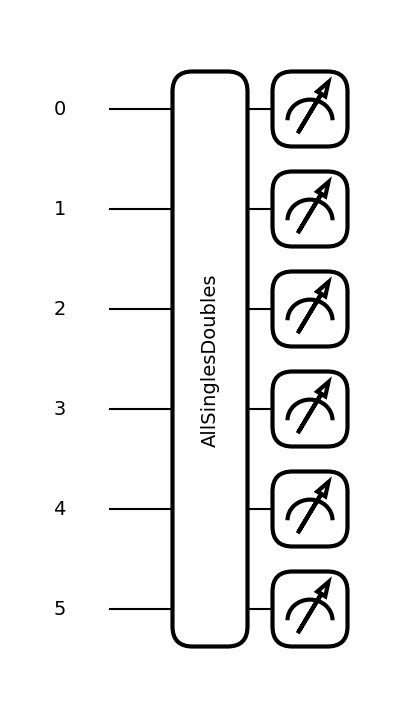

In [39]:
#Draw circuit
qml.draw_mpl(H3_rx_circuit)(params)
## C: TA ERRADO AQUI, ver exatamente o que ele colocou  

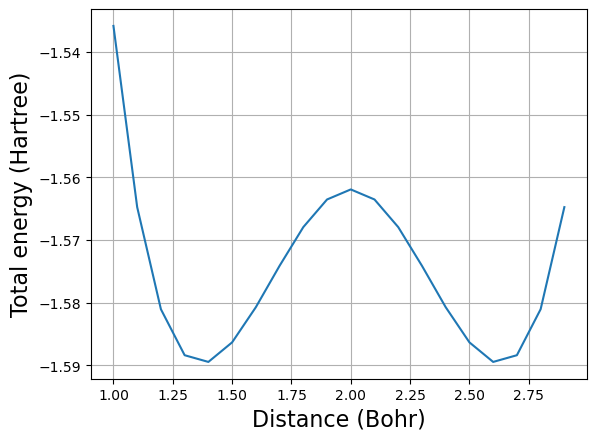

In [34]:
#Plot PES
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(r_range, energies)


ax.set_xlabel('Distance (Bohr)', fontsize=16)
ax.set_ylabel('Total energy (Hartree)', fontsize=16)


ax.grid()
plt.show()

From the potential energy surface (PES), we can estimate the activation energy by calculating the difference between the energy of the reactants and the energy of the transition state.

In [40]:
# Energy of the reactants and products - two minima on the PES
e_eq1 = min(energies)
e_eq2 = min([x for x in energies if x != e_eq1])

idx1 = energies.index(e_eq1)
idx2 = energies.index(e_eq2)

# Transition state is the local maximum between reactant and products
idx_min = min(idx1, idx2)
idx_max = max(idx1, idx2)

# Transition state energy
energy_ts = max(energies[idx_min:idx_max])

# Activation energy
activation_energy = energy_ts - e_eq1

print(f"The activation energy is {activation_energy:.6f} Hartrees")

The activation energy is 0.027504 Hartrees


We can interpret this result by comparing the scale of the activation with the scale of thermal flucuations and the chemical accuracy standard (comparable with experimental accuracy).

We can also explore the sensivity of our estimate of the reaction relative to the accuracy of our computation.

In [41]:
#Boltzmann constant in atomic units (Hartee/Kelvin)
k_B=3.167e-6

#Temperature in Kelvin
T = 300

#Energy scale of thermal fluctuations
print("Energy scale of thermal fluctuations", k_B*T, "Ha")

#Standard of scale of experimental accuracy
print("Chemical accuracy: 0.0016 Ha")

#What happens to our estimate of the reaction rate if we underestimate the activation energy by 10%?
ratio = pnp.exp(-activation_energy / (k_B * T))/pnp.exp(-(activation_energy*0.90) / (k_B * T))

print(f"Ratio of reaction rates is {ratio:.5f}")

Energy scale of thermal fluctuations 0.0009501 Ha
Chemical accuracy: 0.0016 Ha
Ratio of reaction rates is 0.05531


# Introduction to Datasets (time-permitting)

A quantum dataset is a collection of data that describes quantum systems and their evolution. We refer to such data features as quantum data, which in the context of quantum programming, can be realized as the input arguments and outputs of a quantum function that defines a quantum system. (Source: [pennylane.ai/datasets](https://pennylane.ai/datasets/what-is-a-quantum-dataset))

Easy access to large data is integral to quantum computing research – especially as quantum algorithms and hardware scale. PennyLane Datasets make it easier to browse available datasets, and find exactly what you are looking for.

In [2]:
# Load dataset for H3


In [1]:
#Get the Hamiltonian of the H3 molecule


In [3]:
# Get the number of qubits needed for simulating the molecule and the length of Hamiltonian


In [4]:
# VQE with datasets




In [5]:
# Get the ground state energy estimate


In [6]:
# Look at the gates used in the ansatz of the variational circuit


In [7]:
# Access the parameters of the gates used in the ansatz


# Example 2: LiH molecule

Use the datasets to find the ground state energy for the LiH molecule for a bond length of 1.57 Å.

# Copyright
Copyright 2024 Xanadu Quantum Technologies Inc.

Please do not distribute this material outside of your organization.

Unless required by applicable law or agreed to in writing, software distributed
under this training is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR
CONDITIONS OF ANY KIND, either express or implied.